Fisrt of all, I will download the Cifar 10 dataset and prepare the data for the further tasks.

In [1]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import math

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
torch.manual_seed(55)

from torch.utils.data import DataLoader
from torch import optim

from tqdm.auto import tqdm

from sklearn.linear_model import LogisticRegression

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


I have downloaded the dataset and will perform unpickle on the files. Then, i will separetely create the train, validation and test sets.

In [3]:
path = "/content/drive/My Drive/cifar-10-batches-py"

# read in the image net labels
with open('/content/drive/My Drive/imagenet_classes.txt') as f:
    imagenetLabels = [line.strip() for line in f.readlines()]

def unpickle(file):
    with open(file, "rb") as fo:
        dict = pickle.load(fo,encoding="bytes")
    return dict

From the 5 batches of training data, I will combine first 4 batches and make training set and make the 5th batch my validation set.

In [4]:
#creating empty train, validation, test sets
trainingSet = np.empty((4),dtype=object)
validationSet = np.empty((1),dtype=object)
testSet = np.empty((1),dtype=object)

# unpickling train, validation and test sets
trainingSet[0] = unpickle(path+"/data_batch_1")
trainingSet[1] = unpickle(path+"/data_batch_2")
trainingSet[2] = unpickle(path+"/data_batch_3")
trainingSet[3] = unpickle(path+"/data_batch_4")

validationSet[0] = unpickle(path+"/data_batch_5")

testSet[0] = unpickle(path+"/test_batch")

metaData = unpickle(path+"/batches.meta")

In [5]:
metaData[b'label_names']

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

(-0.5, 31.5, 31.5, -0.5)

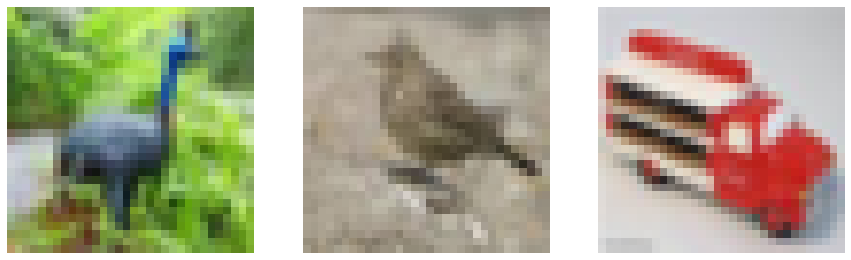

In [6]:
# Display some images
X = trainingSet[0][b"data"] 
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

fig = plt.figure(figsize=(15,10))
fig.add_subplot(1,3,1)
plt.imshow(X[6])
plt.axis('off')
fig.add_subplot(1,3,2)
plt.imshow(X[120])
plt.axis('off')
fig.add_subplot(1,3,3)
plt.imshow(X[360])
plt.axis('off')

Now, we need to prepare the data by the follwing classes and fuctions. Each batch is a numpy array. As each row of the array stores a image, I will reshape in 32x32. Then, assign the first 1024 entries which contains the red channel values, the next 1024 the green, and the final 1024 the blue. for labels, the number at index i indicates the label of the ith image in the array data ranging from 0-9. After that, data augmentation will be performed.

In [7]:
#setting data and label
class train(torch.utils.data.Dataset):
    def __init__(self,batch,b_type,transform):
        self.transform = transform
        self.data = np.concatenate((batch[0][b'data'],batch[1][b'data'],batch[2][b'data'],batch[3][b'data']),axis=0)
            
        self.label = np.concatenate((batch[0][b'labels'],batch[1][b'labels'],batch[2][b'labels'],batch[3][b'labels']))
        
    def __len__(self):
        return len(self.label)

    def __getitem__(self,index):
        label = self.label[index]
        data = self.data[index]

        image = np.transpose(np.array([data[:1024].reshape(32,32),data[1024:2048].reshape(32,32),data[2048:].reshape(32,32)]),(1,2,0))

        if self.transform is not None:
            image = self.transform(image)
    
        return image, label

class test(torch.utils.data.Dataset):
    def __init__(self,batch,b_type,transform):
        self.transform = transform
        self.data = batch[0][b'data']
        self.label = batch[0][b'labels']

    def __len__(self):
        return len(self.label)

    def __getitem__(self,index):
        label = self.label[index]
        data = self.data[index]

        image = np.transpose(np.array([data[:1024].reshape(32,32),data[1024:2048].reshape(32,32),data[2048:].reshape(32,32)]),(1,2,0))

        if self.transform is not None:
            image = self.transform(image)
    
        return image, label

In [8]:
#data augmentation
imageDataGenerator = {"test":transforms.Compose([transforms.ToPILImage(),
                                       transforms.Resize(224),
                                       transforms.ToTensor()])}

#final dataset
train = DataLoader(train(trainingSet,"train",imageDataGenerator["test"]),batch_size=500,shuffle=False)
validation = DataLoader(test(validationSet,"validation", imageDataGenerator["test"]),batch_size=500,shuffle=False)
test = DataLoader(test(testSet,"test",imageDataGenerator["test"]),batch_size=500,shuffle=False)

I will download the alexnet model pretrained with imagenet dataset.

In [9]:
#importing alexnet
AlexNet = models.alexnet(pretrained=True)
AlexNet.cuda()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [10]:
trainingSet[0][b'data'].shape

(10000, 3072)

Now, i will run through test batch's each image and use alexnet model to make prediction for the image. Through this, I will get our prediction and true label list. from there, I will sort the list to get the top 10 prediction list.

In [11]:
# top predictions from alex net

predictionNum = np.zeros(1000)
trueLabelNum = np.zeros(10)
prediction = []
trueLabel = []

with torch.no_grad():
    for batch, (images,labels) in enumerate(test):
        images, labels = images.to("cuda"), labels.to("cuda")
            
        images = images.float()
        labels = labels.type(torch.long) 

        outputs = AlexNet(images)

        m, predictions = torch.max(outputs.data,1)
        for i in predictions:
            predictionNum[i] += 1
        for i in labels:
            trueLabelNum[i] += 1
        prediction.extend(predictions.to("cpu"))
        trueLabel.extend(labels.to("cpu"))


topPrediction=  predictionNum.argsort()[-10:][::-1]
topPredictionNum = predictionNum[topPrediction]
print(topPrediction)
print(topPredictionNum)

tenFreq = []

for i in topPrediction:
  tenFreq.append(imagenetLabels[i])
  print(imagenetLabels[i])

[901 680  80 351 111 190 653 556 712 813]
[2476. 1906.  609.  391.  388.  375.  374.  331.  302.  204.]
901, whiskey_jug
680, nipple
80, black_grouse
351, hartebeest
111, nematode
190, Sealyham_terrier
653, milk_can
556, fire_screen
712, Petri_dish
813, spatula


Now, I will extract only the top 10 predicted names from the predicted list.

In [12]:
predicted_names = []
for i in topPrediction:
  predicted_names.append(imagenetLabels[i][4:])
predicted_names

[' whiskey_jug',
 ' nipple',
 'black_grouse',
 ' hartebeest',
 ' nematode',
 ' Sealyham_terrier',
 ' milk_can',
 ' fire_screen',
 ' Petri_dish',
 ' spatula']

After that, I will create the confusion matrix. First, a list with top predictions according to label count is created. Then, a list with true value according to label count is created. Combining both the list, the confusion matrix is created.

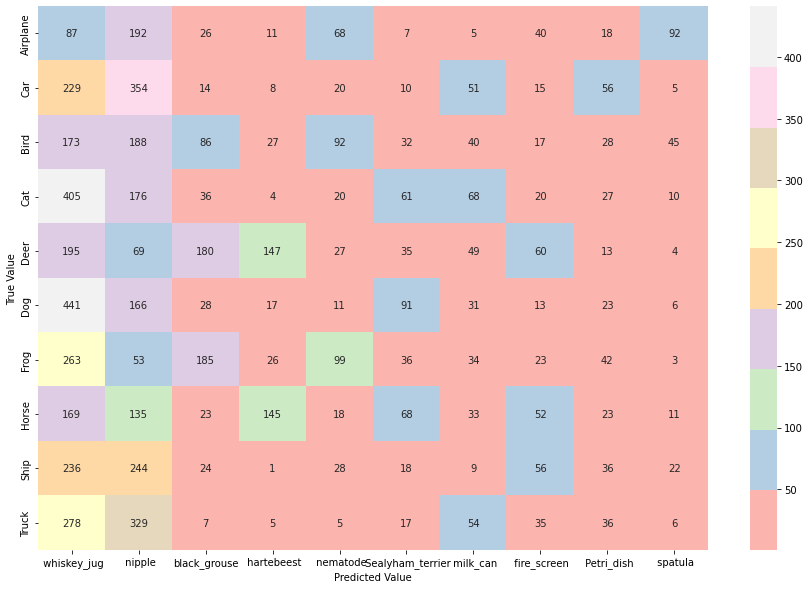

In [13]:
# Build confusion matrix
predictedArr = np.array(prediction)
trueArr = np.array(trueLabel)

TopPredict = [imagenetLabels[i] for i in predictedArr]  

index = [] 
for idx,each in enumerate(TopPredict):
    if each in tenFreq:
        index.append(idx)

predictedValue = [tenFreq.index(TopPredict[i]) for i in index] 

trueValue = [trueArr[i] for i in index] 

Matrix= confusion_matrix(trueValue, predictedValue)

fig = plt.figure(figsize=(15,10))
ax= plt.subplot()
sn.heatmap(Matrix,cmap = "Pastel1", annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Predicted Value')
ax.xaxis.set_ticklabels(predicted_names)
ax.set_ylabel('True Value')
ax.yaxis.set_ticklabels(['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck'])

plt.show()

Downloading the alexnet model pretrained with imagenet dataset.

In [14]:
AlexNet2 = models.alexnet(pretrained=True)
AlexNet2.cuda()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

From the alexnet classifier, removing the last 2 fully connected layers.

In [15]:
AlexNet2.classifier = nn.Sequential(
    nn.Dropout(0.5,False),
    nn.Linear(9216,4096,True)
)
AlexNet2.cuda()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Now, the following method will run through the train, validation and test datasets's each image and use alexnet model to make feature extraction. Through this, I will get our output and label list. from there, will convert both list to nparray to prepare it for logistic regression.

In [16]:
def output(model, data):

    labelset = [] 
    dataset = [] 
    with torch.no_grad():
        for batch, (images,labels) in enumerate(data):
            images, labels = images.to("cuda"), labels.to("cuda")

            images = images.float()
            labels = labels.type(torch.long)

            pred = model(images)
            pred = pred.cpu().detach().numpy()

            labelset.extend(labels.to("cpu"))
            dataset.extend(pred)

    labelset= np.array(labelset)
    dataset = np.array(dataset)
    return dataset, labelset

In [17]:
# output of training data
trainOutput, trainLabels = output(AlexNet2,train)

In [18]:
# output of validation data
validOutput, validLabels = output(AlexNet2,validation)

In [19]:
# output of test data
testOutput, testLabels = output(AlexNet2,test)

Now, I will train a logistic regression classifier on the features extracted by the fc6 layer.

In [20]:
#logistic regression model

logisticRegression = LogisticRegression(verbose=1,n_jobs=-1,solver='lbfgs',penalty='l2')


In [21]:
# fit the model
logisticRegression.fit(trainOutput,trainLabels)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  6.1min finished


LogisticRegression(n_jobs=-1, verbose=1)

Now, the train, validation and test accuracy are gained from the trained model.

In [22]:
#  training accuracy
trainAccuracy = logisticRegression.score(trainOutput,trainLabels)
print("Training accuracy: ",trainAccuracy*100,"%")

#  validation accuracy
validAccuracy = logisticRegression.score(validOutput,validLabels)
print("Validaction accuracy: ", validAccuracy*100,"%")

#  test and accuracy
testAccuracy = logisticRegression.score(testOutput,testLabels)
print("Test accuracy: ", testAccuracy*100,"%")


Training accuracy:  84.245 %
Validaction accuracy:  65.64999999999999 %
Test accuracy:  65.5 %


Downloading the alexnet model pretrained with imagenet dataset.

In [23]:
AlexNet3 = models.alexnet(pretrained=True)
AlexNet3.cuda()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

From the alexnet classifier, removing the last fully connected layer.

In [24]:

AlexNet3.classifier = nn.Sequential(
    nn.Dropout(0.5,False),
    nn.Linear(9216,4096,True),
    nn.ReLU(True),
    nn.Dropout(0.5,False),
    nn.Linear(4096,4096,True)   
)
AlexNet3.cuda()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [25]:
# output of training data
trainOutput2, trainLabels2 = output(AlexNet3,train)

In [26]:
# output of validation data
validOutput2, validLabels2 = output(AlexNet3,validation)

In [27]:
# output of test data
testOutput2, testLabels2 = output(AlexNet3,test)

Now, I will train a logistic regression classifier on the features extracted by the fc6 layer.

In [28]:
#logistic regression model

logisticRegression2 = LogisticRegression(verbose=1,n_jobs=-1,solver='lbfgs',penalty='l2')


In [29]:
# fit the model
logisticRegression2.fit(trainOutput2,trainLabels2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  6.5min finished


LogisticRegression(n_jobs=-1, verbose=1)

Now, the train, validation and test accuracy are gained from the trained model.

In [30]:
# training accuracy
trainAccuracy2 = logisticRegression2.score(trainOutput2,trainLabels2)
print("Training accuracy: ",trainAccuracy2*100,"%")

# validation accuracy
validAccuracy2 = logisticRegression2.score(validOutput2,validLabels2)
print("Validaction accuracy: ", validAccuracy2*100,"%")

# test and accuracy
testAccuracy2 = logisticRegression2.score(testOutput2,testLabels2)
print("Test accuracy: ", testAccuracy2*100,"%")


Training accuracy:  72.345 %
Validaction accuracy:  48.449999999999996 %
Test accuracy:  48.63 %


In [40]:
#Comparison
models = pd.DataFrame({
    'Layer': ['fc6', 
              'fc6',
              'fc6',
              'fc7',
              'fc7',
              'fc7'],
    'Dataset': ['Training Accuracy', 
              'Validation Accuracy',
             'Test Accuracy',
             'Training Accuracy',
             'Validation Accuracy',
             'Test Accuracy'],
    'Score': [round(trainAccuracy*100,2),round(validAccuracy*100,2), round(testAccuracy*100,2), round(trainAccuracy2*100,2),round(validAccuracy2*100,2), round(testAccuracy2*100,2)]})
models.sort_values(by='Layer',ascending=True)

,Layer,Dataset,Score
0,fc6,Training Accuracy,84.24
1,fc6,Validation Accuracy,65.65
2,fc6,Test Accuracy,65.50
3,fc7,Training Accuracy,72.34
4,fc7,Validation Accuracy,48.45
5,fc7,Test Accuracy,48.63


We can see that, the fc6 layers output gives us better result than fc7. In both cases, we can see validation accuracy is much less than training accuracy which can indicate data overfitting. The result indicates that the earlier fully connected layers may contain valuable information about the features of the images. Extracting feature vectors can result in higher accuracies achievable by selecting the best layer for feature extraction. In this case, fc6 layer turned out to be the best layer for feature extraction. Going from fc6 to fc7 layer caused loss of valuable feature information which can be noticed from the test accuracy of fc7 layer output.